# Análisis de performance de agentes
## Búsqueda no informada

In [9]:
import Agents
import random
import multiprocessing as mp
import pandas as pd
import seaborn as sns

## Se llevará a cabo con la siguiente configuración:

In [10]:
agent_types = [Agents.GoalAgentBFS, Agents.GoalAgentDFS, Agents.GoalAgentDLS, Agents.GoalAgentUCS]
size = 100
obstacle_rate = 0.1
depth_dls = 141
iterations = 30  # Per enviroment.
random.seed(0x0303456)

---

## Correr simulación

In [11]:
def run_simulation_1env(simulations, agent_types, size, obstacle_rate, depth_dls):
    # Create common env
    env = Agents.Environment((size, size), (random.randint(0, size - 1), random.randint(0, size - 1)),
                             (random.randint(0, size - 1), random.randint(0, size - 1)), obstacle_rate)
    # Run in each agent
    for agent_type in agent_types:
        # Depth in DLS
        if agent_type == Agents.GoalAgentDLS:
            agent = agent_type(env, depth_dls)
        else:
            agent = agent_type(env)
            
        # Run agent
        path = agent.think()

        # Append results in the siumlations dict
        simulations.append({
            'agent_type': agent_type.__name__,
            'goal_reached': len(path) > 0,
            'solution_length': len(path),
            'explored_states': agent.explored_states
        })

In [12]:
# Using parallelism :D
with mp.Manager() as manager:
    simulations = manager.list() #List thread-safe. (overkill, find alternatives)
    pool = mp.Pool() #use all available cores, otherwise specify the number you want as an argument
    
    # Test iterations
    for i in range(iterations):
        pool.apply_async(run_simulation_1env, args=(simulations, agent_types, size, obstacle_rate, depth_dls))

    # Wait for all threads to finish
    pool.close()
    pool.join()
    
    # Save it as a pandas dataframe
    simulations_df = pd.DataFrame(list(simulations))

simulations_df

,agent_type,goal_reached,solution_length,explored_states
0,GoalAgentBFS,True,36,1261
1,GoalAgentBFS,True,40,2399
2,GoalAgentBFS,True,46,2714
3,GoalAgentDFS,True,1074,1335
4,GoalAgentBFS,True,67,4463
...,...,...,...,...
115,GoalAgentDFS,True,739,2970
116,GoalAgentDLS,False,0,3533
117,GoalAgentUCS,True,91,5094
118,GoalAgentUCS,True,65,5682


## Análisis del performance de cada algorítmo

In [13]:
samples_list = []

for agent_type in agent_types:
    sample_df = simulations_df.query(f'agent_type == "{agent_type.__name__}"')

    samples_list.append({
        'agent_type': agent_type.__name__,
        'goal_reached_n': sample_df.goal_reached.value_counts().loc[True],
        'solution_length_avg': sample_df['solution_length'].mean(),
        'solution_length_std': sample_df['solution_length'].std(),
        'explored_states_avg': sample_df['explored_states'].mean(),
        'explored_states_std': sample_df['explored_states'].std()
    })

# Print table
samples_df = pd.DataFrame(samples_list)
samples_df

,agent_type,goal_reached_n,solution_length_avg,solution_length_std,explored_states_avg,explored_states_std
0,GoalAgentBFS,30,72.500000,40.184703,4886.433333,2749.584416
1,GoalAgentDFS,30,964.900000,740.700710,4603.533333,2791.845907
2,GoalAgentDLS,13,48.766667,62.595959,2412.133333,1205.821189
3,GoalAgentUCS,30,72.500000,40.184703,4886.433333,2749.584416


## Gráficos
### Box plot - Estados explorados por algorítmo

Text(0.5, 1.0, 'Explored states by algorithm')

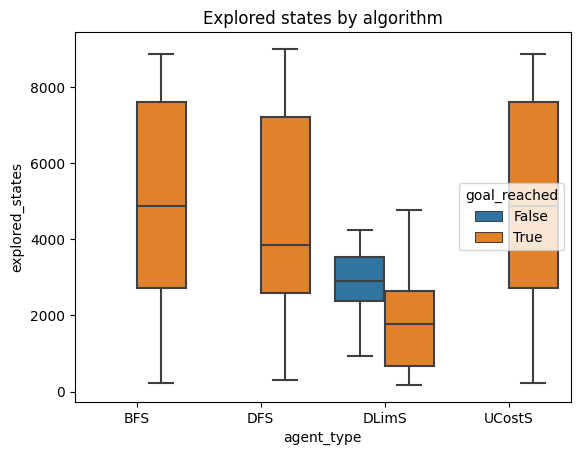

In [14]:
%matplotlib inline

boxplot = sns.boxplot(data=simulations_df, x='agent_type', y='explored_states', hue="goal_reached", order=[x.__name__ for x in agent_types])
boxplot.set_xticklabels(['BFS', 'DFS', 'DLimS', 'UCostS'])
boxplot.set_title('Explored states by algorithm')

### Box plot - Tamaño de las soluciones

Text(0.5, 1.0, 'Solution size by algorithm (linear)')

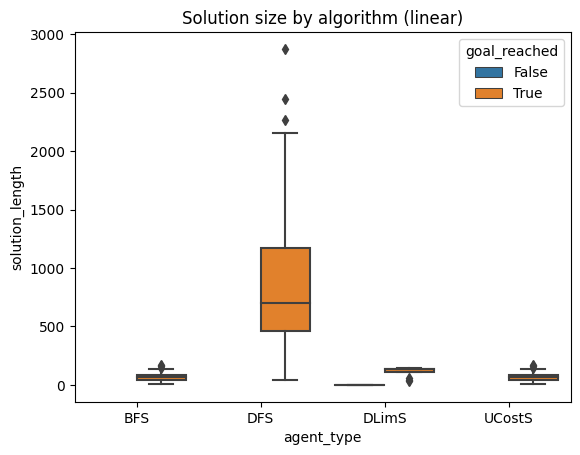

In [15]:
%matplotlib inline

boxplot = sns.boxplot(data=simulations_df, x='agent_type', y='solution_length', hue="goal_reached", order=[x.__name__ for x in agent_types])
boxplot.set_xticklabels(['BFS', 'DFS', 'DLimS', 'UCostS'])
boxplot.set_title('Solution size by algorithm (linear)')

Text(0.5, 1.0, 'Solution size by algorithm (logarithmic)')

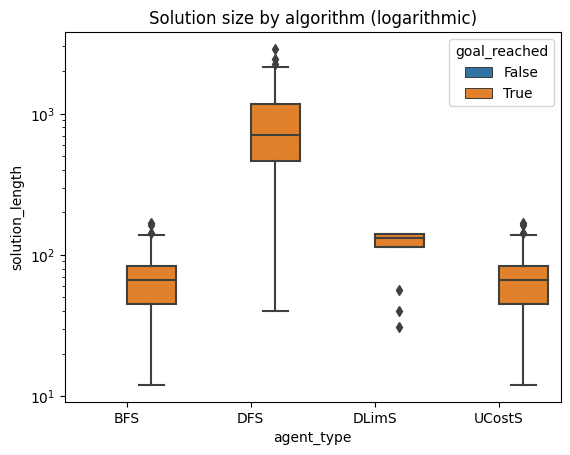

In [16]:
%matplotlib inline
boxplot = sns.boxplot(data=simulations_df, x='agent_type', y='solution_length', hue="goal_reached", order=[x.__name__ for x in agent_types])
boxplot.set_xticklabels(['BFS', 'DFS', 'DLimS', 'UCostS'])
boxplot.set(yscale='log')
boxplot.set_title('Solution size by algorithm (logarithmic)')